# Régression non-paramétrique 

**Objectif**

- vérifier l'hypothèse de hazard proportionnel
- régression non-paramétrique et paramétrique
- choisir le meilleur modèle pour chaque


**Tableau.** Notre démarche pour les régressions non-paramétriques.

| Régressions non-paramétriques testées           | **Critère de sélection**            |
|:------------------------------------------------|:------------------------------------|
| - Cox proportionnel                             | - indice de concordance             |
| - Aalen additif                                 | - MAE de prédiction (cross-validée) |
| - Aalen additif avec pénalité (hyper-paramètre) |                                     |

**Tableau.** Notre démarche pour les régressions paramétriques.

| Régressions paramétriques testées       | **Critère de sélection**            |
|:----------------------------------------|:------------------------------------|
| - Weibull AFT                           | - AIC                               |
| - Exponentiel par morceaux (3 morceaux) | - BIC                               |
| - Exponentiel par morceaux (5 morceaux) | - MAE de prédiction (cross-validée) |

In [1]:
import numpy as np
import pandas as pd
from lifelines import *
from lifelines import (
    AalenAdditiveFitter,
    CoxPHFitter,
    LogNormalAFTFitter,
    PiecewiseExponentialRegressionFitter,
    WeibullAFTFitter,
    WeibullFitter,
)
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model, k_fold_cross_validation
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

from src.data.load_data import get_df
from src.utils import init_notebook

In [2]:
init_notebook()

## Données

In [3]:
df = get_df()

In [4]:
df = df[
    [
        "day_succ",
        "Status",
        "has_video",
        "facebook_connected",
        "goal",
        "facebook_friends",
    ]
]

In [5]:
event_times = df["day_succ"]
event_observed = df["Status"]

In [6]:
cph = CoxPHFitter()
cph.fit(df, duration_col="day_succ", event_col="Status")

C:\Users\AB2-PC\Documents\GitHub\ab2\kickstarter-project-analysis\.venv\lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 18093 total observations, 9065 right-censored observations>

## Vérification du hazard proportionnel

In [8]:
# cph.check_assumptions(df, show_plots=True)

## Modèles non-paramétrique

### Modèle de Cox

In [9]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 18093 total observations, 9065 right-censored observations>
             duration col = 'day_succ'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 18093
number of events observed = 9028
   partial log-likelihood = -82929.05
         time fit was run = 2025-03-13 16:39:17 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
has_video           0.60      1.83      0.03            0.54            0.67                1.71                1.95
facebook_connected -0.06      0.94      0.02           -0.11           -0.02                0.90                0.98
goal               -6.52      0.00      0.41           -7.32           -5.73                0.00                0.00
facebook_friends    0.13      1.14      0.01            0.11            0.15                1.12                1.16

                    cmp to      z      p  -log2(p)
covariate                                         
has_video             0.00  17.91 <0.005    235.78
facebook_connected    0.00  -2.66   0.01      6.99
goal                  0.00 -16.07 <0.005    190.71
facebook_friends      0.00  13.93 <0.005    144.09
---
Concordance = 0.63
Partial AIC = 165866.09
log-likelihood ratio test = 1449.86 on 4 df
-log2(p) of ll-ratio test = inf

<Axes: >

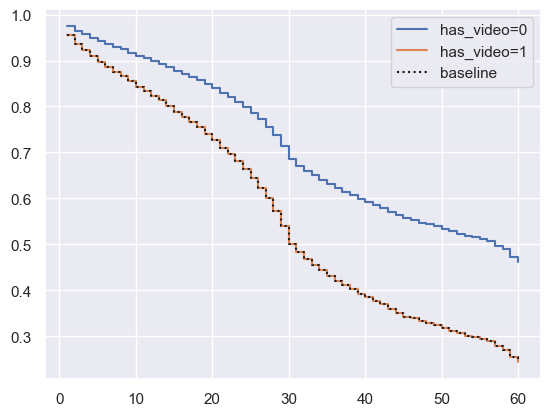

In [10]:
cph.plot_partial_effects_on_outcome(covariates="has_video", values=[0, 1])

### Cross-validation (Cox & Aalen additif)

In [11]:
# create the three models we'd like to compare.
aaf_1 = AalenAdditiveFitter(coef_penalizer=0)
aaf_2 = AalenAdditiveFitter(coef_penalizer=10)
cph = CoxPHFitter()

In [12]:
def moyenne_cross_val(model, df: pd.DataFrame):
    return np.mean(
        k_fold_cross_validation(
            model,
            df,
            duration_col="day_succ",
            event_col="Status",
            scoring_method="concordance_index",
        )
    )

In [13]:
models_list = {
    "Cox proportionnel": cph,
    "Aalen Additive (sans pénalité)": aaf_1,
    "Aalen Additive (pénalité 10)": aaf_2,
}

cox_tab = {
    "Modèle": [],
    "Indice de concordance": [],
}  # todo: rename

for model in models_list.keys():
    m = models_list[model]
    moy = moyenne_cross_val(m, df)

    cox_tab["Modèle"].append(model)
    cox_tab["Indice de concordance"].append(moy)

In [ ]:
# print(pd.DataFrame(cox_tab).to_markdown(index=False))

**Tableau.** Comparaison des modèles de régression non-paramétriques.

| Modèle                         |   Indice de concordance |
|:-------------------------------|------------------------:|
| Cox proportionnel              |                0.656568 |
| Aalen Additive (sans pénalité) |                0.586883 |
| Aalen Additive (pénalité 10)   |                0.588575 |

Interprétation : 
- indice de concordance **> 0.5** => performance **supérieure** à du hasard
- indice de concordance **= 0.5** => performance **équivalente** à du hasard
- indice de concordance **< 0.5** => performance **inférieure** à du hasard

Choix : **modèle de Cox proportionnel**

## Prédictions

In [14]:
models_nonparam = {
    "Cox proportionnel": cph,
    "Aalen additif (sans pénalité)": aaf_1,
    "Aalen additif (avec pénalité=10)": aaf_2,
}

models_param = {
    "Weibull AFT": WeibullAFTFitter(),
    "Exponentiel morceaux (3)": PiecewiseExponentialRegressionFitter(
        breakpoints=[9, 21, 29]
    ),
    "Exponentiel morceaux (5)": PiecewiseExponentialRegressionFitter(
        breakpoints=[10, 20, 30, 40, 50]
    ),
}

In [15]:
res_models = {
    "Modèle": [],
    "AIC": [],
    "BIC": [],
    "MAE": [],
}

In [16]:
for model_name in models_nonparam.keys():
    model = models_nonparam[model_name]
    model.fit(df, duration_col="day_succ", event_col="Status")

    y_pred = model.predict_expectation(df)
    mae = mean_absolute_error(event_times, y_pred)

    res_models["Modèle"].append(model_name)
    res_models["MAE"].append(mae)
    res_models["AIC"].append(np.nan)
    res_models["BIC"].append(np.nan)

In [17]:
for model_name in models_param.keys():
    model = models_param[model_name]
    model.fit(df, duration_col="day_succ", event_col="Status")

    y_pred = model.predict_expectation(df)
    mae = mean_absolute_error(event_times, y_pred)

    res_models["Modèle"].append(model_name)
    res_models["MAE"].append(mae)
    res_models["AIC"].append(model.AIC_)
    res_models["BIC"].append(model.BIC_)

C:\Users\AB2-PC\Documents\GitHub\ab2\kickstarter-project-analysis\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\AB2-PC\Documents\GitHub\ab2\kickstarter-project-analysis\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
# print(pd.DataFrame(res_models).to_markdown(index=False))

**Tableau.** Résultats des modèles de régression

| Modèle                           |     AIC |     BIC |          MAE |
|:---------------------------------|--------:|--------:|-------------:|
| Cox proportionnel                |   nan   |   nan   | 13.6055      |
| Aalen additif (sans pénalité)    |   nan   |   nan   | 13.9461      |
| Aalen additif (avec pénalité=10) |   nan   |   nan   | 14.0145      |
| Weibull AFT                      | 19465.7 | 19470.3 |  3.24738e+77 |
| Exponentiel morceaux (3)         | 19127.7 | 19121.1 | 13.0742      |
| Exponentiel morceaux (5)         | 19138.1 | 19128.1 | 13.2367      |


Meilleur modèle : **exponentiel par morceaux (3)**

Nos 3 meilleurs modèles de régression sont :
1) Exponenentiel morceaux (3)
2) Exponentiel morceaux (5)
3) Cox proportionnel